***
# Yelp Reviews 
***

***
# About
***

Take a small set of reviews, from **Yelp**, and predict the rating based on the user written comment. For this project we will utilize `Naive Bayes`, `Logistic Regression` and `Decision Tree`.  

We will start by framing this as a **binary classification problem** by reviewing only **5-Star** and **1-Star** reviews. Then we will make it a **5-class** classification problem by using the ratings 1 - 5.

This dataset is only 10,000 observations from the original dataset in CSV format. The full dataset and rules for the competition can be found [here](https://www.kaggle.com/c/yelp-recsys-2013/overview). The next phase will be taking the concepts practiced on this smaller dataset and use on the full dataset to achieve a score lower than 1.21250 (RMSE). 

* [Large Yelp Dataset JSON](https://www.kaggle.com/yelp-dataset/yelp-dataset)
* [Yelp Recruiting Competition - Kaggle](https://www.kaggle.com/c/yelp-recruiting/overview)

***
# Index
***
[Imports & Functions](#imports_functions)


[EDA Process](#eda)
* Data, Shape & Unique Counts
* Skewness 


[5-Star & 1-Star Only](#five_one)


[Model Evaluation](#model_eval)
* Train, Test, Split
* CountVectorizer
* Transform Training & Testing Data


[Multinominal Naive Bayes](#nb)
* Accuracy Score
* Cross Validation k-fold
* Null Accuracy 
* Confusion Matrix
* Classification Matrix 
* Exploring Type I Errors
* Review Attributes of Classifier 
* Calculating Predictability Each Word


[Logistic Regression](#logreg)
* Cross Validation 
* Accuracy Score 


[Full Dataset](#full)
* Accuracy Score 
* Null Accuracy 
* Confusion Matrix 
* Classification Report 
* Logistic Regression w/Cross Validation 
* Naive Bayes w/Cross Validation 
* Decision Tree w/Cross Validation 

[Summary & Recommendation](#sum)

<a id="imports_functions"></a>
<div class="alert alert-block alert-info">
    <font size="+3"><b>Imports & Functions</b></font>
</div>

In [228]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report
from sklearn import tree
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn import metrics
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestRegressor

In [229]:
# Custom Hist Functions
def hist(d_frame, col_name,title="",y_axis="",x_axis="",binsize=1):
    '''Create a histogram with binsize auto set to 1'''
    bins = np.arange(0,d_frame[col_name].max()+binsize,binsize)
    plt.axvline(d_frame[col_name].median(),color='y',linestyle='--',lw=2,label='Median')
    plt.axvline(d_frame[col_name].mean(),color='r',linestyle='--',lw=2,label='Mean')
    plt.title(title,fontsize=14)
    plt.ylabel(y_axis,fontsize=14)
    plt.xlabel(x_axis,fontsize=14)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    plt.legend(fontsize=14)
    return plt.hist(d_frame[col_name],bins=bins);

<a id="eda"></a>
<div class="alert alert-block alert-info">
    <font size="+3"><b>EDA Process</b></font>
</div>

In [309]:
# import the data
file = 'yelp.csv'
df = pd.read_csv(file)

## Data
Looking at the data for the first time the initial thought is we will only need to use two features.  This will be `stars` and `text`. Based on the text feature we will try and predict the the number of stars the user rated that business.  

In [231]:
df.head()

,business_id,date,review_id,stars,text,type,user_id,cool,useful,funny
0,9yKzy9PApeiPPOUJEtnvkg,2011-01-26,fWKvX83p0-ka4JS3dc6E5A,5,My wife took me here on my birthday for breakf...,review,rLtl8ZkDX5vH5nAx9C3q5Q,2,5,0
1,ZRJwVLyzEJq1VAihDhYiow,2011-07-27,IjZ33sJrzXqU-0X6U8NwyA,5,I have no idea why some people give bad review...,review,0a2KyEL0d3Yb1V6aivbIuQ,0,0,0
2,6oRAC4uyJCsJl1X0WZpVSA,2012-06-14,IESLBzqUCLdSzSqm0eCSxQ,4,love the gyro plate. Rice is so good and I als...,review,0hT2KtfLiobPvh6cDC8JQg,0,1,0
3,_1QQZuf4zZOyFCvXc0o6Vg,2010-05-27,G-WvGaISbqqaMHlNnByodA,5,"Rosie, Dakota, and I LOVE Chaparral Dog Park!!...",review,uZetl9T0NcROGOyFfughhg,1,2,0
4,6ozycU1RpktNG2-1BroVtw,2012-01-05,1uJFq2r5QfJG_6ExMRCaGw,5,General Manager Scott Petello is a good egg!!!...,review,vYmM4KTsC8ZfQBg-j5MWkw,0,0,0


## Shape and Unique Counts 
The dataset is 10,000 observations with 10 features of which our initial primary focus will be on `text` and `stars`. However, we should poke around the dataset to confirm this is what we want.  

1. Taking a look at the unique counts of a few features we see that `text` is almost 100 percent unique with exception of 2 reviews. 
2. `Stars` is equal to 5 so this confirm there are not any errors 
3. `Type ID` is 1 so we are only doing an analysis on the type `reviews`. There are probably other review classifications for Yelp but we are not aware of these type and at this time are probably not a concern.  However, if we wanted to move forward with using our model on another `review type` we would need to introduce that review type into our model training. 4.  `Business ID` indicates that about 40% of the business is unique and as anticipated the `review id` is 100 percent unique.
5. Of the users submitting reviews `64 percent` are unique.
6. `Cool`, `Useful` and `Funny` are not on a 1 - 5 rating. They have values that are substantially higher with a higher spread which is most likely attributed the expanded rating scale. For now these will be ignored. 

In [232]:
# shape of the dataframe
df.shape

(10000, 10)

In [233]:
# unique counts
print(f"Text Unqique Count:\t\t {df['text'].nunique()}")
print(f"Stars ID Unqique Count:\t\t {df['stars'].nunique()}")
print(f"Type ID Unqique Count:\t\t {df['type'].nunique()}")
print(f"Business ID Unqique Count:\t {df['business_id'].nunique()}")
print(f"Review ID Unqique Count:\t {df['review_id'].nunique()}")
print(f"User ID Unqique Count:\t\t {df['user_id'].nunique()}")

Text Unqique Count:		 9998
Stars ID Unqique Count:		 5
Type ID Unqique Count:		 1
Business ID Unqique Count:	 4174
Review ID Unqique Count:	 10000
User ID Unqique Count:		 6403


## Skewness
The 5 star rating system for this data set is skewed to the left with with a mean of **3.77** and a median of **4.00**. 

In [234]:
# stats num data
df.describe()

,stars,cool,useful,funny
count,10000.000000,10000.000000,10000.000000,10000.000000
mean,3.777500,0.876800,1.409300,0.701300
std,1.214636,2.067861,2.336647,1.907942
min,1.000000,0.000000,0.000000,0.000000
25%,3.000000,0.000000,0.000000,0.000000
50%,4.000000,0.000000,1.000000,0.000000
75%,5.000000,1.000000,2.000000,1.000000
max,5.000000,77.000000,76.000000,57.000000


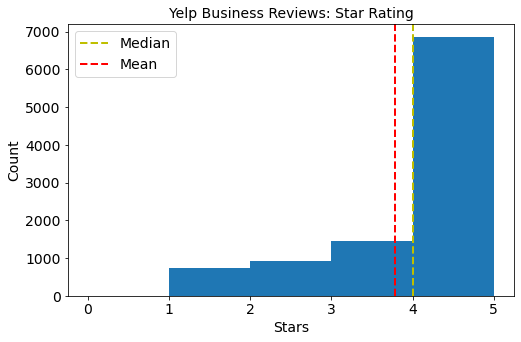

In [235]:
plt.figure(figsize = [8,5])
hist(df,'stars','Yelp Business Reviews: Star Rating', 'Count', 'Stars');

<a id="five_one"></a>
<div class="alert alert-block alert-info">
    <font size="+3"><b>5-Star & 1-Star</b></font>
</div>

### 5-Star & 1-Start Count
After dropping 2, 3 and 4 star reviews there is a total of **4,086** observations. The new dataframe will be called `df2`.
* **5-Star** 3,337
* **1-Star** 749

In [236]:
# Create and valdiate the new dataframe only has 5 and 1 star ratings
df2 = df[(df['stars'] > 4) | (df['stars'] < 2)]
df2['stars'].value_counts()

5    3337
1     749
Name: stars, dtype: int64

In [237]:
# check the observation count 
print(f"Shape df2: {df2.shape}")
print(f"Shape df: {df.shape}")

Shape df2: (4086, 10)
Shape df: (10000, 10)


### Split Data
Here we are going to split the data into 4 sections. We will use `X` and `y` for the full dataset (10,000 observations). The modified dataset with only `5-Star` and `1-Star` ratings will be assigned to `X2` and `y2`. `X2` will be the **text** and `y2` will be the **ratings**, which is either a 5 or 1.  The data type will be a panda series.  

In [238]:
# X will be the text data which needs to be 1d and y will be 1d, as always
X2 = df2['text']
y2 = df2['stars']

# split based on all 10,000 observastions 
X = df['text']
y = df['stars']

In [239]:
# check data type should be a panda series or np array for passing to CountVectorizer
print(type(X2))
print(type(y2))
print('*'*10 + 'Confirm panda Series' + '*'*10)
print(type(X))
print(type(y))

<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
**********Confirm panda Series**********
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>


<a id="model_eval"></a>
### Model Evaluation 
Now we want to decide what model evaluation to use.  Typically, we do not want to train and test our data on the same data set.  For our evaluation process we will use **Train, Test, Split** and **K-fold cross-validation**.  We can compare them to determine which one to use on the full dataset. 


1. **Train/test split**
  * Split the dataset into two pieces, so that the model can be trained and tested on different data
  * Useful due to its speed, simplicity, and flexibility
  * Default split is 75/25 where 75 equals training


2. **K-fold cross-validation**
  * Using stratified sampling to create "K" train/test splits and average the results together
  * Typically k = 10
  * Runs "K" times slower than train/test split 

### Train, Test, Split

In [240]:
# Split X2 and y2 data for training and testing
X2_train, X2_test, y2_train, y2_test = train_test_split(X2, y2, random_state=42)

# Split X and y...based on the original 'df'
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [241]:
# Check the shape after applying train, test, split
print('Validate shape of data for X2 and y2')
print(f"X2_train Shape:\t{X2_train.shape}")
print(f"X2_test Shape:\t{X2_test.shape}")
print(f"y2_train Shape:\t{y2_train.shape}")
print(f"y2_test Shape:\t{y2_test.shape}\n")

print('Validate shape of data for X and y')
print(f"X_train Shape:\t{X_train.shape}")
print(f"X_test Shape:\t{X_test.shape}")
print(f"y_train Shape:\t{y_train.shape}")
print(f"y_test Shape:\t{y_test.shape}")

Validate shape of data for X2 and y2
X2_train Shape:	(3064,)
X2_test Shape:	(1022,)
y2_train Shape:	(3064,)
y2_test Shape:	(1022,)

Validate shape of data for X and y
X_train Shape:	(7500,)
X_test Shape:	(2500,)
y_train Shape:	(7500,)
y_test Shape:	(2500,)


### CountVectorizer
Using `CountVectorizer` from sklearn will convert a collection of text documents to a matrix of `token counts`. The returned result will be a sparse representation of the `counts` using `scipy.sparse.csr_matrix`. 

We apply **vect** using the sklearn `fit() method` and this should only be completed on the training data. Fit will learn a vocabulary dictionary of all `tokens` in the raw documents. At this point we are NOT adjusting any of the default parameters.  One default to remember is `token_pattern` which is a a regualr expression selects only words/tokens of **2** or more alphanumeric characters (punctuation is completely ignored).

In [242]:
# learn training data vocabulary, then use it to create a document-term matrix
# this happens in-place 
vect = CountVectorizer()
# fit X2_train 5/1 star dataset
vect.fit(X2_train)
# full dataset 
vect.fit(X_train)

CountVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
                lowercase=True, max_df=1.0, max_features=None, min_df=1,
                ngram_range=(1, 1), preprocessor=None, stop_words=None,
                strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
                tokenizer=None, vocabulary=None)

### Transform Training and Testing Data
In the transforming process we are using the fitted vocabulary to create a 
`Document-term matrix` (DTM). **NOTE**, we used two individual methods: `fit()` and `transform()`.  We could have done this in ONE step using `fit_transform()` which does both steps at the same time.  

**NOTE** we could have only used `fit_transform()` on the training data as we do not want to fit the testing data. If we fit() the testing data then our testing data would have learned the vocabulary which would artificially create a good predictive model. 

In [243]:
# transform testing data (using fitted vocabulary) into a document-term matrix
X2_train_dtm = vect.transform(X2_train)
X2_test_dtm = vect.transform(X2_test)

# transform the full dataset
X_train_dtm = vect.transform(X_train)
X_test_dtm = vect.transform(X_test)

In [244]:
# training data 5/1 star only
X2_train_dtm

<3064x25800 sparse matrix of type '<class 'numpy.int64'>'
	with 235335 stored elements in Compressed Sparse Row format>

In [245]:
# testing data 5/1 star only
X2_test_dtm

<1022x25800 sparse matrix of type '<class 'numpy.int64'>'
	with 80457 stored elements in Compressed Sparse Row format>

In [246]:
# training data full dataset
X_train_dtm

<7500x25800 sparse matrix of type '<class 'numpy.int64'>'
	with 624610 stored elements in Compressed Sparse Row format>

In [247]:
# testing data  full dataset
X_test_dtm

<2500x25800 sparse matrix of type '<class 'numpy.int64'>'
	with 198816 stored elements in Compressed Sparse Row format>

<a id="nb"></a>
## Multinominal Naive Bayes Model 
Here we will use the Multinominal Naive Bayes classifier to create one one each dataset and we will label them `nb` and `nb2`. Note the difference in time it takes to run the models. These are small datasets so imagine when they increase how much time this process can take. When we run logistic regression on the full data set it will probably be around 30 ms. 

After creating the classifier we will use `fit()` method to fit the Naive Bayes classifier according to X2 and y2. As well, X and y for the full dataset. Then using the `predict()` method we cna perform classification on an array of test vectors: X and X2.  


[Multinominal Naive Bayes](https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.MultinomialNB.html)

In [248]:
# create  a NB classifier called nb2
nb2 = MultinomialNB()

# Train two models nb and nb2
# compare model and time for how long it takes (recall this is SMALL data set)
%time nb2.fit(X2_train_dtm, y2_train)

Wall time: 2.97 ms


MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

In [249]:
# create  a NB classifier called nb based on full dataset
nb = MultinomialNB()
%time nb.fit(X_train_dtm, y_train)

Wall time: 7.96 ms


MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

## Making Predictions 
Now we want to make predictions using the testing data. Using 

In [250]:
# make class predictions for X2_test_dtm
y2_pred_class = nb2.predict(X2_test_dtm)

# make class predictions for X_test_dtm (Full dataset)
y_pred_class = nb.predict(X_test_dtm)

### Accuracy Score
This will measure the difference between **y** and **$\hat{y}$**. To use input a 1d array of `y-values` and `y-predicted` values.  Recall, we want to use the prediction class
that comes from our test data which has **NOT** seen the fit process. 

The accuracy score for this model using only 5-Star and 1-Star reviews is 90%. 


[Accuracy Score](https://scikit-learn.org/stable/modules/model_evaluation.html#accuracy-score)

In [251]:
# check the accuracy score 
metrics.accuracy_score(y2_test, y2_pred_class)

0.901174168297456

### Cross Validation Score 
Keeping with the simple approach we will now use `sklearn cross validation` to measure the accuracy of our model. A couple of reasons we like using K-fold Cross-Validation:
1. It automatically splits the data for us. In the code below the first three arguments are:
  * the classifier which is set to `MultiNominalNB()` 
  * all of the learned text converted to document-term matrix.  NOTE: For a logistic regression problem this would just be "X". 
  * The third argument is all of the 5 and 1 start ratings
2. Better predictor of how the model will preform with data in production 

We have Cross validation set at `CV=5` meaning 5 stratified random samples will be taken and the accuracy score will be returned. The is the first output below and the second output is the mean score of those 5 samples.  NOTE: Stratified sampling ensures each of the k folds has a balanced mix. 

Based on the improved score this will be the process used for validation of the larger dataset. 

[Cross-validation Docs](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_val_score.html)

In [252]:
from sklearn.model_selection import cross_val_score

# fit_transform all 5-Star and 1-Star reviews into a document-term matrix
# Also, ntoe here we can just use fit_transform
X2_dtm = vect.fit_transform(X2)

# this wil be used latter on when we run model on all reviews 
X_dtm = vect.fit_transform(X)

print(cross_val_score(nb2, X2_dtm, y2, cv=5,scoring='accuracy'))
print(f"Mean Score: {cross_val_score(nb2, X2_dtm, y2, cv=5,scoring='accuracy').mean()}")

[0.89853301 0.92166463 0.93145655 0.92288862 0.92900857]
Mean Score: 0.9207102734376169


### Null Accuracy 
Using the sklearn accuracy score we found that our `NB` classifier predicted the correct start rating 90% of the time. Is 90% accuracy good enough? One way to look at this is to calculate the `Null Accuracy` and use this as a baseline for our comparison.  

The `Null Accuracy` in taking the most frequent class and predicting that value each time. In our example this would be the greater of `5-star` and `1-star` reviews.  We can obtain this by taking the count of `y_test` and for the constructed NB the greater of the two is 5-star ratings at 80%.

Thus, our classifier predicts 10% better than what could have been done by simply selecting 5 star reviews each time.  Is this good enough?

In [253]:
# calculate the number of 5 and 1 star reviews 
five_stars = y2_test.value_counts()
print(f"5 Stars count: {five_stars.iloc[0]}")
print(f"1 Stars count: {five_stars.iloc[1]}")

5 Stars count: 823
1 Stars count: 199


In [254]:
# as a percent 
print(f"5-Stars as Percent of Testing Data: {five_stars.iloc[0]/len(y2_test)}")
print(f"1-Stars as Percent of Testing Data: {five_stars.iloc[1]/len(y2_test)}")

5-Stars as Percent of Testing Data: 0.8052837573385518
1-Stars as Percent of Testing Data: 0.19471624266144813


### Confusion Matrix 
Looking at the confusing matrix we want to now explore the predictions that our model did not predict correctly. The `False Positive` or `Type I Error` for this dataset was predicting a 5-star review when it was actually a 1 star. This occurred 76 times compared with the `False Negative` or `Type II Error` which occurred 18 times. 
**Positive** = 5
**Negative** = 1


- Upper left: True Negative Correctly Predicted 1-Star Reviews
- Lower Left: False Negative Falsely Predicted 1-Star Reviews  
- Upper Right: False Positive Falsely Predicted 5-Star Reviews
- Lower Right: True Positive Correctly Predicted 5-Star Reviews

In [255]:
# calcualte the confusion matrix
# actual or True y results are always first in sklearn
cm2 = metrics.confusion_matrix(y2_test, y2_pred_class)
cm2

array([[108,  91],
       [ 10, 813]], dtype=int64)

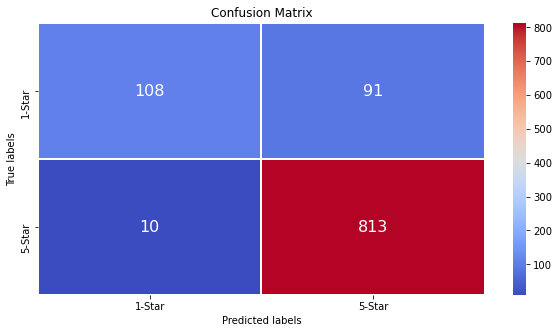

In [256]:
# plot the confusion matrix
plt.figure(figsize = [10,5])
ax= plt.subplot()
sns.heatmap(cm2, annot=True, ax = ax,fmt="d",annot_kws={'size':16},
            linewidths=1.0, cmap="coolwarm"); #annot=True to annotate cells

ax.set_xlabel('Predicted labels');
ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(['1-Star', '5-Star']); 
ax.yaxis.set_ticklabels(['1-Star', '5-Star']);

## Classification Matrix 
* **Accuracy**: 
  * Overall how often is the classifier correct. 
  * Adding all the numbers along the diagonal (TP + TN) / Total 
  
  
* **Misclassification Rate**:
  * Overall, how often is it wrong
  * (FP + FN) / Total 
  * Also called the `Error Rate`
  
  
* **True Positive Rate**
  * Also called `Recall`  or `Sensitivity`
  * Recall =  TP / (TP + FN)
  * Out of `all` the positive classes, how much we predicted correctly
  
  
* **False Positive Rate**  
  * How often do we predict True but its actually False
  * FP / (FP + TN)
  
  
* **True Negative Rate or Specificity**  
  * How often do we predict False but its actually True
  * TN / (FP + TN)
  * Also, equal to 1 - False Positive Rate
  
  
* **Precision**
  * Precision = TP / (TP + FP)
  * Out of all the True predictions we made...how correct where those predictions
  * TP / (TP + FP)

In [257]:
# run classification report 
target_names = ['1-Star', '5-Star']
print(classification_report(y2_test, y2_pred_class, target_names=target_names))

              precision    recall  f1-score   support

      1-Star       0.92      0.54      0.68       199
      5-Star       0.90      0.99      0.94       823

    accuracy                           0.90      1022
   macro avg       0.91      0.77      0.81      1022
weighted avg       0.90      0.90      0.89      1022



In [258]:
# manual calculations for confusion matrix and classification report
tn, fn, fp, tp = cm2[0,0], cm2[1,0], cm2[0,1] , cm2[1,1]
print(f"Total =\t\t\t\t {tn+fn+fp+tp}")
print(f"Accuracy =\t\t\t {round((tp+tn) /(tn+fn+fp+tp),4)}")
print(f"Misclassification Rate =\t {round((fp+fn) /(tn+fn+fp+tp),4)}")
print(f"True Positive Rate (Recall) =\t {round((tp) /(fn+tp),4)}")
print(f"False Positive Rate =\t\t {round((fp) /(fp+tn),4)}")
print(f"True Negative Rate =\t\t {round((tn) /(fp+tn),4)}")
print(f"Precision =\t\t\t {round((tp) /(fp+tp),4)}")

Total =				 1022
Accuracy =			 0.9012
Misclassification Rate =	 0.0988
True Positive Rate (Recall) =	 0.9878
False Positive Rate =		 0.4573
True Negative Rate =		 0.5427
Precision =			 0.8993


In [259]:
# create a dataframe of the actual results from the test data 'y_actual' and 
# the predicted values 
df2_results = pd.DataFrame(data={'y2_actual': y2_test, 'y2_prediction':y2_pred_class})
df2_results.shape

(1022, 2)

In [260]:
# False positive 
df2_false_pos = df2_results.query('y2_actual == 1 and y2_prediction == 5')
df2_false_pos.shape

(91, 2)

In [261]:
# False negative
df2_false_neg = df2_results.query('y2_actual == 5 and y2_prediction == 1')
df2_false_neg.shape

(10, 2)

In [262]:
# true positive
df2_true_pos = df2_results.query('y2_actual == 5 and y2_prediction == 5')
df2_true_pos.shape

(813, 2)

In [263]:
# true negative
df2_true_neg = df2_results.query('y2_actual == 1 and y2_prediction == 1')
df2_true_neg.shape

(108, 2)

### Exploring Type I Errors (False Positive)
Lets take a more detailed look at the `false positives` to see if there is anything that indicated whey these values have been incorrectly classified.  

In [264]:
# merge results with the test data on the index
df2_merged_results = df2_results.merge(X2_test,left_index=True,right_index=True)
df2_merged_results

,y2_actual,y2_prediction,text
1406,1,5,"From my door, it's a five minute stroll throug..."
1792,5,5,This is by far the best Chicken Fried Steak ar...
7723,5,5,Ok so us 5 hot chix got all dolled up for dinn...
2416,5,5,Located in the space formerly occupied by LGO'...
6111,5,5,Does anyone know why their regular subs are $1...
...,...,...,...
4729,5,5,Alas...I've given up the idea of writing a rev...
3305,5,5,This has got to be the best barber shop I've e...
2249,5,5,Simple but really great cajun food prepared in...
1443,5,5,Awesome food anyone??? Go check out Modern Ste...


In [265]:
# export the false positives for Excel for visual review
false_pos2 = df2_merged_results.query('y2_actual == 1 and y2_prediction == 5')
false_pos2.to_excel('false_positives.xlsx',sheet_name='false_pos2',index=True)

In [266]:
# export the false positives for Excel for visual review
true_neg2 = df2_merged_results.query('y2_actual == 1 and y2_prediction == 1')
true_neg2.to_excel('true_neg.xlsx',sheet_name='true_neg2',index=True)

### The Stats Type I Error Review Length 
We wanted to look at some quick stats on false positive and true negative to check if there is anything that might provide a quick indication into the Type I Error. We calculated the length of each review and the stats are similar. The mean character count was 770 for false positives and 825 for true positives. The assumption was there would be a large difference in the mean that might explain the false positive.  We can dig into this in more detail if we are not able to find a reason for the false positives.  


1. **False Positive** (76 times predicted "5" actual was "1")
2. **True Positive** (805 times predicted "5" actual was "5")

In [267]:
# calculate the length of each review 
from statistics import mean, stdev, variance
false_pos_len = []
for i in range(len(false_pos2['text'])):
    false_pos_len.append( len(false_pos2['text'].iloc[i]) )
    
print(f"Mean False Positive:\t\t {mean(false_pos_len)}")
print(f"Max False Positive:\t\t {max(false_pos_len)}")
print(f"Min False Positive:\t\t {min(false_pos_len)}")
print(f"variance False Positive:\t {variance(false_pos_len)}")
print(f"Std False Positive:\t\t {stdev(false_pos_len)}")

Mean False Positive:		 839
Max False Positive:		 3163
Min False Positive:		 28
variance False Positive:	 610913.7333333333
Std False Positive:		 781.6097065245117


In [268]:
# calculate the length of each review 
true_neg_len = []
for i in range(len(true_neg2['text'])):
    true_neg_len.append( len(true_neg2['text'].iloc[i]) )
    
print(f"Mean False Positive:\t\t {mean(true_neg_len)}")
print(f"Max False Positive:\t\t {max(true_neg_len)}")
print(f"Min False Positive:\t\t {min(true_neg_len)}")
print(f"variance False Positive:\t {variance(true_neg_len)}")
print(f"Std False Positive:\t\t {stdev(true_neg_len)}")

Mean False Positive:		 775.1481481481482
Max False Positive:		 3523
Min False Positive:		 57
variance False Positive:	 401518.12737971614
Std False Positive:		 633.6545804929656


### Convert X2_test Feature Names DataFrame
To help explore the `Document-Term Matrix` created for `X2_test` we will convert it to a dataframe that will have 1,022 observations by 16,712 words.  Then we will sum each column and create another dataframe with a column called `word_count`. The index will be the actual words that we can then sort and call `nlargest` on to view the words.  

In [269]:
X2_test_dtm.shape

(1022, 25800)

In [270]:
# create initial dataframe from X_test 
X2_test_dtm = vect.transform(X2_test)
col_names = vect.get_feature_names()
df2_feature_names =  pd.DataFrame(X2_test_dtm.toarray(), columns=col_names)
df2_feature_names.shape

(1022, 29185)

In [271]:
# modify the dataframe from above and show the TOP 25
df2_feature_names_sum = df2_feature_names.sum(axis=0)
df2_new = pd.DataFrame(df2_feature_names_sum,columns=['word_count'])
df2_new.sort_values(by=['word_count'],inplace=True,ascending=False)
df2_new['word_count'].nlargest(n=25)

the      6197
and      4326
to       3009
of       2005
it       1890
was      1730
is       1701
for      1503
in       1498
that     1236
my       1180
you      1113
with     1092
this     1075
we       1022
they      993
on        857
have      846
but       846
had       717
not       704
are       701
at        673
place     660
so        649
Name: word_count, dtype: int64

### MultinominalNB Attributes

**Attributes:** 
1. `class_count_` Number of samples encountered for each class during fitting. This value is weighted by the sample weight when provided.  X_train has a shape of (3064,) which is aligned with the split `array([ 550., 2514.])` returned below. **550** would be the number of 1-star reviews and **2514** would be the 5-star reviews. 


2. `classes_` returns the labels known to the classifier. array([1, 5]) tells is correct and confirm the order that sklearn returns 


3. `n_features_` returns the number of features. Our classifier created 16,712 words from the reviews in X_test. 


4. `feature_count_` Number of samples encountered for each (class, feature) during fitting. This value is weighted by the sample weight when provided. For this dataset it will return an array `2 x 16,712` that will have all the features broken down by number of times in each class: `5-Star and 1-Star`.

In [272]:
# class_count_ provides 
nb2.class_count_

array([ 550., 2514.])

In [273]:
nb2.classes_

array([1, 5], dtype=int64)

In [274]:
nb2.n_features_

25800

In [275]:
# print the shape of feature_count_
nb2.feature_count_.shape

(2, 25800)

In [276]:
# index 0 of array is 1-star 
# index 1 of array is 5-star
nb2.feature_count_

array([[28.,  4.,  1., ...,  0.,  0.,  0.],
       [38.,  5.,  0., ...,  1.,  1.,  0.]])

## Calculating Predictability of Each Word
Here we are going to create a DataFrame with all of the `words` from the reviews broken down by count by `class` where class is 1-star and 5-star.  This will allow us to view the top kth words that are associated with 1-star and 5-star reviews.  

In [277]:
# class_count_ provides 
X2_train_dtm = vect.transform(X2_train)
nb2.fit(X2_train_dtm, y2_train)
nb2.class_count_

array([ 550., 2514.])

In [278]:
# number of times each token appears across 1-star reviews
token_count_1star = nb2.feature_count_[0, :]
token_count_1star

array([28.,  4.,  0., ...,  0.,  0.,  0.])

In [279]:
# number of times each token appears across 5-star reviews
token_count_5star = nb2.feature_count_[1, :]
token_count_5star

array([38.,  5.,  0., ...,  1.,  1.,  0.])

In [280]:
# store the vocabulary of X_train
X2_train_tokens = vect.get_feature_names()
len(X2_train_tokens)

29185

In [281]:
# create a DataFrame of tokens with their separate 1 star and 5 star counts 
df2_tokens =  pd.DataFrame({'token':X2_train_tokens, 'one_star':token_count_1star, 
                                  'five_star':token_count_5star}).set_index('token')
df2_tokens.shape

(29185, 2)

In [282]:
df2_tokens.sample(10)

,one_star,five_star
token,,
buttering,0.0,0.0
houseshow,0.0,0.0
chaude,0.0,0.0
forsaken,0.0,1.0
alfafa,0.0,0.0
plank,0.0,2.0
extremly,0.0,2.0
ilk,0.0,1.0
extrudes,0.0,0.0


In [283]:
# add 1 to the counts to avoid dividing by 0 when converting to percents
df2_tokens['one_star'] = df2_tokens['one_star'] + 1
df2_tokens['five_star'] = df2_tokens['five_star'] + 1
df2_tokens.sample(5)

,one_star,five_star
token,,
barback,1.0,2.0
tablet,1.0,2.0
deserve,5.0,9.0
egalitarian,1.0,1.0
kinetic,1.0,1.0


In [284]:
# convert the counts into frequencies
# Now we can understand better the impact of word
df2_tokens['one_star_freq'] = df2_tokens['one_star'] / nb2.class_count_[0]
df2_tokens['five_star_freq'] = df2_tokens['five_star'] / nb2.class_count_[1]
df2_tokens.sample(5)

,one_star,five_star,one_star_freq,five_star_freq
token,,,,
chantrel,2.0,1.0,0.003636,0.000398
crude,1.0,1.0,0.001818,0.000398
poland,1.0,1.0,0.001818,0.000398
scramble,2.0,2.0,0.003636,0.000796
vacated,1.0,1.0,0.001818,0.000398


In [285]:
# calculate the ratio of spam-to-ham for each token
df2_tokens['predict_ratio'] =  df2_tokens['five_star'] / df2_tokens['one_star'] 
df2_tokens['predict_ratio_freq'] =  df2_tokens['five_star_freq'] / df2_tokens['one_star_freq']
df2_tokens.sample(5)

,one_star,five_star,one_star_freq,five_star_freq,predict_ratio,predict_ratio_freq
token,,,,,,
453990,1.0,2.0,0.001818,0.000796,2.000000,0.437550
underwhelmed,3.0,1.0,0.005455,0.000398,0.333333,0.072925
that,951.0,2529.0,1.729091,1.005967,2.659306,0.581789
yowza,1.0,2.0,0.001818,0.000796,2.000000,0.437550
pricey,2.0,43.0,0.003636,0.017104,21.500000,4.703660


In [286]:
df2_tokens['one_star'].nlargest(n=10)

token
the     4198.0
and     2633.0
to      2351.0
was     1484.0
it      1327.0
of      1266.0
that     951.0
in       948.0
for      941.0
my       878.0
Name: one_star, dtype: float64

In [287]:
df2_tokens['five_star'].nlargest(n=10)

token
the    14014.0
and    10439.0
to      6376.0
of      4532.0
is      4430.0
it      4175.0
in      3448.0
was     3414.0
for     3246.0
you     3027.0
Name: five_star, dtype: float64

In [288]:
df2_tokens['predict_ratio_freq'].nlargest(n=10)

token
fantastic    42.661098
perfect      17.793689
fabulous     17.283214
yum          13.564041
favorite     13.476531
awesome      10.902281
fruit        10.501193
pasty         9.188544
bianco        8.750994
gem           8.750994
Name: predict_ratio_freq, dtype: float64

In [289]:
df2_tokens['predict_ratio_freq'].nlargest(n=10)

token
fantastic    42.661098
perfect      17.793689
fabulous     17.283214
yum          13.564041
favorite     13.476531
awesome      10.902281
fruit        10.501193
pasty         9.188544
bianco        8.750994
gem           8.750994
Name: predict_ratio_freq, dtype: float64

<a id="logreg"></a>
## Logistic Regression 

In [290]:
# classifier log reg
log = LogisticRegression(max_iter=500, solver='liblinear')

In [291]:
# fit_transform all 5-Star and 1-Star reviews into a document-term matrix
# Also, ntoe here we can just use fit_transform
X2_dtm = vect.fit_transform(X2)

# this wil be used latter on when we run model on all reviews 
X_dtm = vect.fit_transform(X)

print(cross_val_score(log, X2_dtm, y2, cv=5,scoring='accuracy'))
print(f"Mean Score: {cross_val_score(log, X2_dtm, y2,cv=5,scoring='accuracy').mean()}")

[0.93765281 0.93268054 0.94124847 0.93268054 0.94614443]
Mean Score: 0.9380813579408235


<a id="full"></a>
<div class="alert alert-block alert-info">
    <font size="+3"><b>Full Dataset</b></font>
</div>

### Accuracy Score 
New we start the review process of the full dataset which will include 2, 3 and 4 star ratings. The counts for each ratings are as follows:

* **4-Star** 3,526
* **5-Star** 3,337
* **3-Star** 1,461
* **2-Star** 927
* **1-Star** 749

Reviewing the accuracy score we find that with adding in the other three ratings are score fell from 90% to 49%.  

In [292]:
# check the accuracy score 
metrics.accuracy_score(y_test, y_pred_class)

0.4932

### Null Accuracy
On the smaller dataset our if we decided to utilize null accuracy we would have selected the 5-start rating for all reviews and been correct 80% of the time which was only 10 points less than our classifier.  For the larger dataset we would select `4-Star` reviews and this would provide a correct prediction of **36 percent** which is 13 points below our classifier accuracy score of **49 percent**.

In [293]:
df['stars'].value_counts()

4    3526
5    3337
3    1461
2     927
1     749
Name: stars, dtype: int64

In [294]:
# calculate count for rating NOTE this is on y_test
stars = y_test.value_counts()
print(f"5 Stars count: {stars.iloc[1]}")
print(f"4 Stars count: {stars.iloc[0]}")
print(f"3 Stars count: {stars.iloc[2]}")
print(f"2 Stars count: {stars.iloc[3]}")
print(f"1 Stars count: {stars.iloc[4]}")

5 Stars count: 826
4 Stars count: 898
3 Stars count: 374
2 Stars count: 221
1 Stars count: 181


In [295]:
# calculate the precent of each rating NOTE this is on y_test
stars = y_test.value_counts()
print(f"5 Star Percent: {stars.iloc[1] / len(y_test)}")
print(f"4 Star Percent: {stars.iloc[0] / len(y_test)}")
print(f"3 Star Percent: {stars.iloc[2] / len(y_test)}")
print(f"2 Star Percent: {stars.iloc[3] / len(y_test)}")
print(f"1 Star Precent: {stars.iloc[4] / len(y_test)}")

5 Star Percent: 0.3304
4 Star Percent: 0.3592
3 Star Percent: 0.1496
2 Star Percent: 0.0884
1 Star Precent: 0.0724


### Confusion Matrix 
Plotting the confusion matrix makes evaluating the results a little easier. We correctly classified 661 of 4-Star reviews and 461 of 5-Star reviews.  Our big miss was predicting 4-star when it was actually a 5-Star which happened 356 times follow by predicting 4-Star but it was actually a 3-Star.  216 times we predicted 5-Star but it was actually 4-Star. 



In [296]:
# calcualte confusion matrix
# actual or True y results are always first in sklearn
cm = metrics.confusion_matrix(y_test, y_pred_class)
cm

array([[ 50,  24,  18,  67,  22],
       [ 16,  21,  38, 124,  22],
       [  5,   9,  40, 278,  42],
       [  8,   4,   9, 661, 216],
       [  4,   0,   5, 356, 461]], dtype=int64)

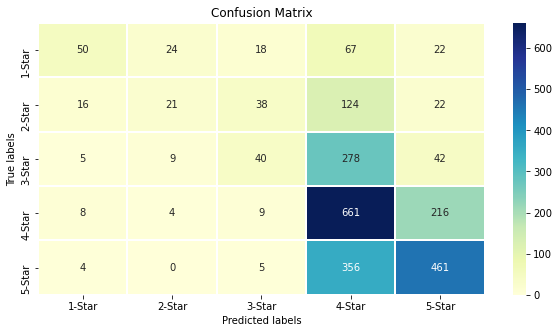

In [297]:
# plot the confusion matrix
plt.figure(figsize = [10,5])
ax= plt.subplot()
sns.heatmap(cm, annot=True, ax = ax,fmt="d",
            linewidths=1.0, cmap="YlGnBu"); #annot=True to annotate cells

ax.set_xlabel('Predicted labels');
ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(['1-Star','2-Star','3-Star','4-Star', '5-Star']); 
ax.yaxis.set_ticklabels(['1-Star','2-Star','3-Star','4-Star', '5-Star']);

In [298]:
a = sum(cm)
print(f"Double Check test is 2,500 observastions: {sum(a)}")

Double Check test is 2,500 observastions: 2500


## Classification Report 
Reviewing the classification report we want to first look at the `Precision Rate` which measures how well the model predicted our ratings.  For `5-Star` ratings the model predicted 60% correctly followed by `1-Star` reviews at 60%, too. The 3 middle values had a much lower precision rate. Does out model predict the ends better?  The `recall rating` for 4-Star reviews was 74 percent. Next, was 5-Star reviews at 56 percent.  

When tunning the model we should explore of to increase the precision score even if results in recall percent reduction. A higher precision on 4 and 3 star reviews will increase accuracy. 

In [299]:
from sklearn.metrics import classification_report

In [300]:
# run classification report 
target_names = ['1-Star','2-Star','3-Star','4-Star', '5-Star']
print(classification_report(y_test, y_pred_class, target_names=target_names))

              precision    recall  f1-score   support

      1-Star       0.60      0.28      0.38       181
      2-Star       0.36      0.10      0.15       221
      3-Star       0.36      0.11      0.17       374
      4-Star       0.44      0.74      0.55       898
      5-Star       0.60      0.56      0.58       826

    accuracy                           0.49      2500
   macro avg       0.48      0.35      0.37      2500
weighted avg       0.49      0.49      0.46      2500



In [301]:
y_test.value_counts()

4    898
5    826
3    374
2    221
1    181
Name: stars, dtype: int64

## Logistic Regression Full Dataset 
Running logistic regression with cross validation set at 5 and 10.  The scores are both at 50% so based on the fact that this dataset is only 10,000 observations if this model was select for production we would want to set `CV` at 5 to reduce training time.  

In [302]:
from sklearn.linear_model import LogisticRegression
log = LogisticRegression(max_iter=500, solver='liblinear')

X_dtm = vect.fit_transform(X)

## Logistic Regression K-Fold Cross Validation  CV = 5

In [303]:
# Full dataset  
cv = 5 
print(cross_val_score(log, X_dtm, y, cv=5,scoring='accuracy'))
print(f"Mean Score: {cross_val_score(log, X_dtm, y,cv=cv,scoring='accuracy').mean()}")

[0.48   0.5035 0.51   0.5025 0.488 ]
Mean Score: 0.4968


## Logistic Regression K-Fold Cross Validation  CV = 10

In [304]:
# Full dataset  
cv = 10
print(cross_val_score(log, X_dtm, y, cv=cv,scoring='accuracy'))
print(f"Mean Score: {cross_val_score(log, X_dtm, y,cv=cv,scoring='accuracy').mean()}")

[0.481 0.492 0.496 0.517 0.509 0.505 0.485 0.526 0.484 0.493]
Mean Score: 0.4988


## MN Naive Bayes K-Fold Cross Validation  CV 5 and CV 10
Here we used the `nb` classifier and set cv=5 and cv = 10. Using NB runs a lot faster compared with logistic regression and because they have similar scores at this point the recommendation would be to use Cross Validation set at 10 with MultionomailNB classifier. 

In [305]:
# Full dataset  with NB
cv = 5 
print(cross_val_score(nb, X_dtm, y, cv=5,scoring='accuracy'))
print(f"Mean Score: {cross_val_score(nb, X_dtm, y,cv=cv,scoring='accuracy').mean()}")

[0.491  0.479  0.496  0.4895 0.4975]
Mean Score: 0.4906


In [306]:
# Full dataset  with NB
cv = 10
print(cross_val_score(nb, X_dtm, y, cv=5,scoring='accuracy'))
print(f"Mean Score: {cross_val_score(nb, X_dtm, y,cv=cv,scoring='accuracy').mean()}")

[0.491  0.479  0.496  0.4895 0.4975]
Mean Score: 0.49639999999999995


## Decision Tree K-Fold Cross Validation  CV 5
The original result with default settings was 0.39 and by adjusting min samples to 22 and max leaf nodes to 25 we achieved a score of 42 percent. We already have two other classifiers at 49% so additional tuning is probably not wise. 

In [307]:
# create the classifier standard  
dt = tree.DecisionTreeClassifier(min_samples_split = 22, 
                                               random_state = 42,
                                               max_leaf_nodes=25)

In [308]:
cv = 5 
print(cross_val_score(dt, X_dtm, y, cv=5,scoring='accuracy'))
print(f"Mean Score: {cross_val_score(dt, X_dtm, y,cv=cv,scoring='accuracy').mean()}")

[0.4115 0.4235 0.4335 0.4135 0.4185]
Mean Score: 0.4201


<a id="sum"></a>
<div class="alert alert-block alert-info">
    <font size="+3"><b>Summary</b></font>
</div>

Based on the work completed the best model would be **MN Naive Bayes** with Cross-Validation set at 10.  This will provide the best prediction of the users rating based on the text.  Additional consideration should be given to optimizing the logistic regression model.

The next step will be to use the model for the initial pass based on the original dataset for the Kaggle Competition.  